# Visualize plate with license/province boxes

Loads local data (no Colab/Drive). Uses car → plate → text-relative bboxes from 8000.csv.


In [1]:
# Imports and paths (local run)
import ast
from pathlib import Path
import numpy as np
import pandas as pd
import cv2
import matplotlib.pyplot as plt
import matplotlib.patches as patches

PROJECT_ROOT = Path(r"C:\Users\Tanaphat\Desktop\Coding\ALPR")
CSV_PATH = PROJECT_ROOT / "data" / "8000" / "8000.csv"
DATA_DIR = PROJECT_ROOT / "data" / "8000"

print(f"CSV: {CSV_PATH}")
print(f"Images root: {DATA_DIR}")
assert CSV_PATH.exists(), "CSV not found; update PROJECT_ROOT if running elsewhere"

CSV: C:\Users\Tanaphat\Desktop\Coding\ALPR\data\8000\8000.csv
Images root: C:\Users\Tanaphat\Desktop\Coding\ALPR\data\8000


In [2]:
# Helpers to parse and convert bboxes
def parse_single_bbox(bbox_str):
    try:
        arr = ast.literal_eval(bbox_str)
        if isinstance(arr, list) and len(arr) > 0:
            return arr[0]
    except Exception:
        return None
    return None


def parse_polygons(poly_str):
    try:
        arr = ast.literal_eval(poly_str)
        if isinstance(arr, list) and len(arr) > 0:
            return [np.array(p) for p in arr]
    except Exception:
        return []
    return []


def polygon_to_xyxy(poly):
    # poly is Nx2
    x_min, y_min = poly[:, 0].min(), poly[:, 1].min()
    x_max, y_max = poly[:, 0].max(), poly[:, 1].max()
    return x_min, y_min, x_max, y_max


def load_image_cv2(img_path: Path):
    img_array = np.fromfile(str(img_path), dtype=np.uint8)
    img = cv2.imdecode(img_array, cv2.IMREAD_COLOR)
    if img is None:
        raise FileNotFoundError(f"Cannot load image: {img_path}")
    return img


def car_plate_char_abs(row):
    car_bbox = parse_single_bbox(row['car_bbox'])
    plate_rel = parse_single_bbox(row['plate_bbox'])
    char_polys_rel = parse_polygons(row['character_bbox']) if 'character_bbox' in row else []

    if car_bbox is None or plate_rel is None:
        return None, None, []

    cx1, cy1, cx2, cy2 = car_bbox
    px1, py1, px2, py2 = plate_rel
    plate_abs = [px1 + cx1, py1 + cy1, px2 + cx1, py2 + cy1]

    chars_abs = []
    for poly in char_polys_rel:
        shifted = poly + np.array([plate_abs[0], plate_abs[1]])
        chars_abs.append(polygon_to_xyxy(shifted))

    return car_bbox, plate_abs, chars_abs

In [3]:
# Load data

df = pd.read_csv(CSV_PATH)
print(f"Rows: {len(df)}")
# Keep validated with required fields
mask = (
    df['is_validate'] == True
) & df['car_bbox'].notna() & df['plate_bbox'].notna() & df['character_bbox'].notna()
df_v = df[mask].copy()
print(f"Usable rows: {len(df_v)}")

Rows: 8172
Usable rows: 8172


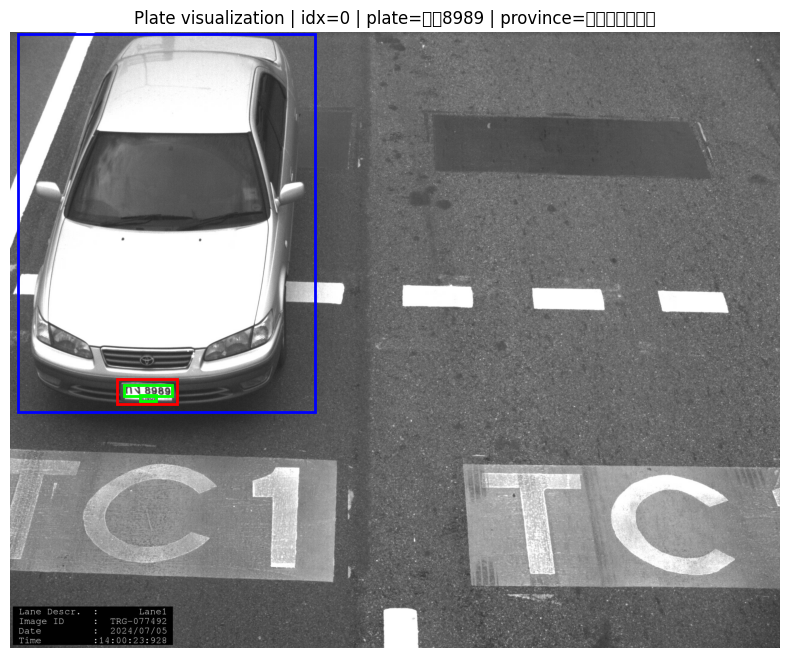

In [5]:
# Visualize one sample by index in df_v

def visualize_row(idx):
    row = df_v.iloc[idx]
    img_rel = row['image_name_gray'] if 'image_name_gray' in row and isinstance(row['image_name_gray'], str) else row['image_name']
    img_path = (DATA_DIR / img_rel.lstrip('/')).resolve()
    img = load_image_cv2(img_path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    h, w = img.shape[:2]

    car_bbox, plate_abs, chars_abs = car_plate_char_abs(row)
    if car_bbox is None or plate_abs is None:
        print("Missing bboxes for this row")
        return

    fig, ax = plt.subplots(1, 1, figsize=(10, 8))
    ax.imshow(img)

    # Draw car bbox
    cx1, cy1, cx2, cy2 = car_bbox
    car_rect = patches.Rectangle((cx1, cy1), cx2 - cx1, cy2 - cy1, linewidth=2, edgecolor='blue', facecolor='none', label='car')
    ax.add_patch(car_rect)

    # Draw plate bbox
    px1, py1, px2, py2 = plate_abs
    plate_rect = patches.Rectangle((px1, py1), px2 - px1, py2 - py1, linewidth=2, edgecolor='red', facecolor='none', label='plate')
    ax.add_patch(plate_rect)

    # Draw characters/province polygons as boxes
    for i, (x1, y1, x2, y2) in enumerate(chars_abs):
        rect = patches.Rectangle((x1, y1), x2 - x1, y2 - y1, linewidth=2, edgecolor='lime', facecolor='none')
        ax.add_patch(rect)
        # ax.text(x1, y1 - 5, f"char {i+1}", color='white', fontsize=9, backgroundcolor='green')

    ax.set_xlim(0, w)
    ax.set_ylim(h, 0)
    ax.axis('off')
    ax.set_title(f"Plate visualization | idx={df_v.index[idx]} | plate={row.get('plate','')} | province={row.get('province_description','')}")
    plt.show()

# Example: visualize first usable row
visualize_row(0)